### Install Required Packages

We would be running `Stable Diffusion 2` so enable `GPU` under `View Resources > Change runtime type`

In [1]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-89bb41cb-9a83-4544-e533-333330daadc6)


In [2]:
%%capture
!pip install diffusers
!pip install daam
!pip install git+https://github.com/RishiDarkDevil/daam-i2i.git
!pip install git+https://github.com/RishiDarkDevil/TITAN.git

### Import Necessary Libraries

We will load the necessary libraries required for generating DAAM outputs for input prompts.

In [3]:
# Plotting
from matplotlib import pyplot as plt

# Data Handling
import numpy as np

# Image Processing
import cv2
from PIL import Image

# Image Generation
from diffusers import StableDiffusionImg2ImgPipeline

# Heatmap generation
import daam
import daami2i

# Model
import torch

# annotations
import titan

### Load Model

In [4]:
DEVICE = 'cuda' # device

Now, let's load the `stabilityai/stable-diffusion-2-base` diffusion model.

In [5]:
STRENGTH = 0.3

In [6]:
model = StableDiffusionImg2ImgPipeline.from_pretrained('stabilityai/stable-diffusion-2-base')
model = model.to(DEVICE) # Set it to something else if needed, make sure DAAM supports that

Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.


Fetching 16 files:   0%|          | 0/16 [00:00<?, ?it/s]

### DAAM Image Attention

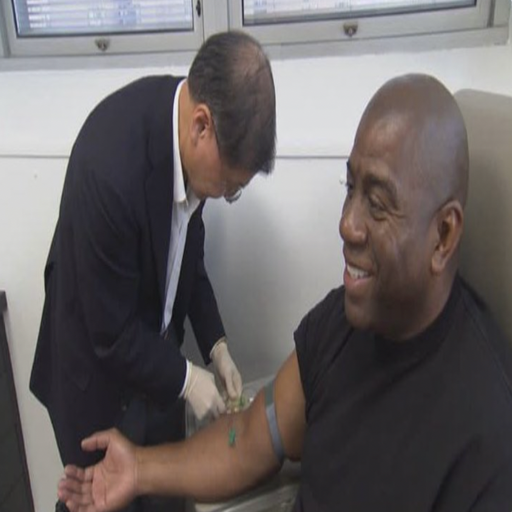

In [7]:
init_img = Image.open('img.png').convert("RGB")
init_img = init_img.resize((512, 512))
init_img

In [8]:
prompt = ['Magic Johnson went to the hospital.']

In [9]:
processed_prompt = titan.PromptHandler().clean_prompt(prompt)

Loading Models...

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


INFO:stanza:Downloading default packages for language: en (English) ...


INFO:stanza:Finished downloading models and saved to /root/stanza_resources.
INFO:stanza:Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


INFO:stanza:Loading these models for language: en (English):
| Processor | Package  |
------------------------
| tokenize  | combined |
| pos       | combined |
| lemma     | combined |

INFO:stanza:Using device: cuda
INFO:stanza:Loading: tokenize
INFO:stanza:Loading: pos
INFO:stanza:Loading: lemma
INFO:stanza:Done loading processors!


Done
Tokenizing...Done
POS Tagging and Lemmatizing...Done
Processing...Done


In [10]:
processed_prompt

[('magic johnson went to the hospital .',
  ['magic', 'johnson', 'hospital'],
  ['magic', 'johnson', 'hospital'])]

In [11]:
with daam.trace(model) as daam_trc:
  with daami2i.trace(model) as daami2i_trc:
    output_image = model(prompt=processed_prompt[0][0], init_image=init_img, strength=STRENGTH, guidance_scale=7.5).images
    image_global_heat_map = daami2i_trc.compute_global_heat_map()
    word_global_heat_map = daam_trc.compute_global_heat_map()

  0%|          | 0/16 [00:00<?, ?it/s]

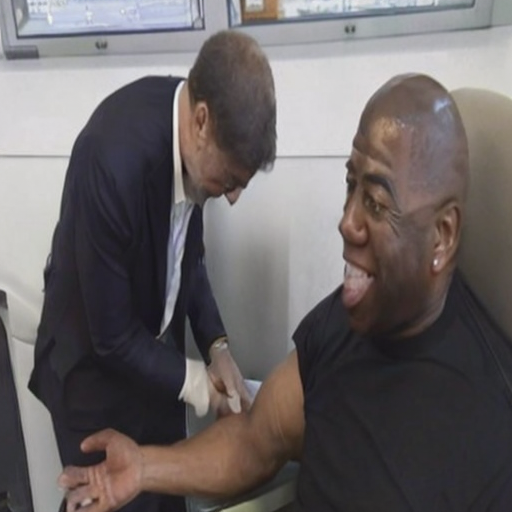

In [13]:
output_image[0]

### Visualize Heatmaps

In [19]:
annotations = list()
object_annotator = titan.ObjectAnnotator()

In [20]:
# for i, word in enumerate(processed_prompt[0][1]):
#   # Compute heatmap for a non-stopword
#   word_heatmap = word_global_heat_map.compute_word_heat_map(word).expand_as(output_image[0]).numpy()

#   # Annotate the Word Heatmap for current word
#   anns = object_annotator.wordheatmap_to_annotations(
#     word_heatmap, 100*i, 1, i
#     )

#   annotations.append(anns)

objects = ['magic johnson', 'hospital']
for i, word in enumerate(objects):
  # Compute heatmap for a non-stopword
  word_heatmap = word_global_heat_map.compute_word_heat_map(word).expand_as(output_image[0]).numpy()

  # Annotate the Word Heatmap for current word
  anns = object_annotator.wordheatmap_to_annotations(
    word_heatmap, 100*i, 1, i
    )

  annotations.append(anns)

In [21]:
len(annotations)

2

In [22]:
len(annotations[0])

3

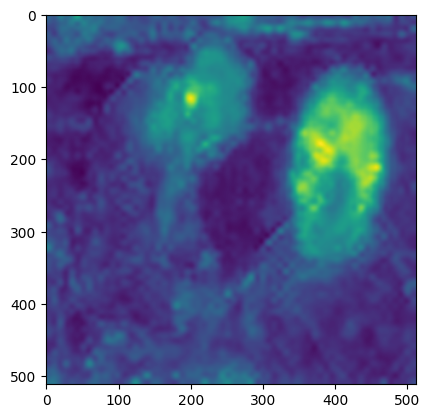

In [23]:
# plt.imshow(word_global_heat_map.compute_word_heat_map(processed_prompt[0][1][0]).expand_as(output_image[0]).numpy())
plt.imshow(word_global_heat_map.compute_word_heat_map(objects[0]).expand_as(output_image[0]).numpy())

In [36]:
heatmaps = list()
for k in range(len(annotations[0])):
  # Compute heatmap for inner pixels for contour boundary specified
  pixel_heatmap = image_global_heat_map.compute_contour_heat_map(
      [[annotations[0][k]['segmentation'][0][i], annotations[0][k]['segmentation'][0][i+1]] for i in range(0, len(annotations[0][k]['segmentation'][0]), 2)], 
      512, 512).expand_as(output_image[0]).numpy()

  # Casting heatmap from 0-1 floating range to 0-255 unsigned 8 bit integer
  heatmap = np.array(pixel_heatmap * 255, dtype = np.uint8)

  heatmaps.append(heatmap[np.newaxis, :, :])

In [37]:
heatmap = np.mean(np.concatenate(heatmaps), 0)

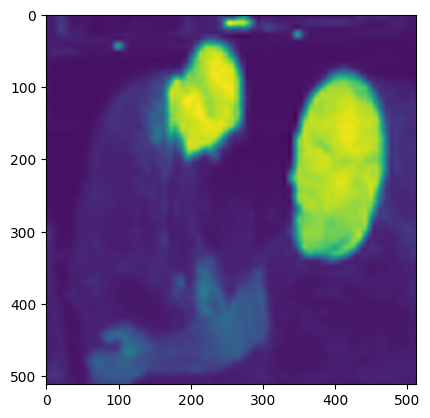

In [26]:
plt.imshow(heatmap)

In [43]:
# word_heatmap
word_heat = word_global_heat_map.compute_word_heat_map(objects[0])

# To store weighted average of all the heatmaps with weights as the text heatmap pixel weights
pixel_heatmap = torch.zeros((image_global_heat_map.latent_h, image_global_heat_map.latent_w))

for i in range(image_global_heat_map.latent_h):
  for j in range(image_global_heat_map.latent_w):
    pixel_heatmap += image_global_heat_map.compute_pixel_heat_map(image_global_heat_map.latent_w * i + j).heatmap.cpu() * word_heat.heatmap.cpu()[i][j].item() ## word_heat is large need to cover it

pixel_heatmap /= word_heat.heatmap.cpu().sum().item()

pixel_heatmap = daami2i.PixelHeatMap(pixel_heatmap).expand_as(output_image[0]).numpy()

# # Casting heatmap from 0-1 floating range to 0-255 unsigned 8 bit integer
heatmap = np.array(pixel_heatmap * 255, dtype = np.uint8)    

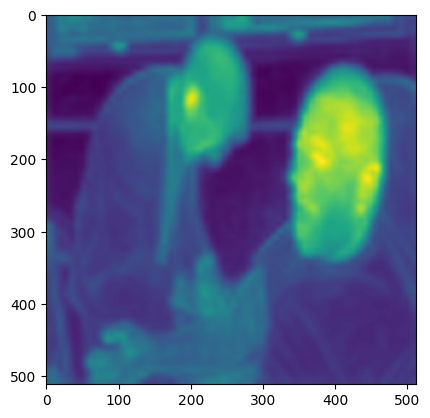

In [28]:
plt.imshow(heatmap)

In [65]:
# Combining both Contours and Weighted

inner_pix_list = list()
for k in range(len(annotations[0])):
  pts = [[annotations[0][k]['segmentation'][0][i], annotations[0][k]['segmentation'][0][i+1]] for i in range(0, len(annotations[0][k]['segmentation'][0]), 2)]
  pts = np.array(np.array(pts) * image_global_heat_map.latent_w / 512, np.int32)
  pts = pts.reshape((-1,1,2))
  inner_pixs = list()
  for i in range(64):
    for j in range(64):
      dist = cv2.pointPolygonTest(pts, (i, j), False)
      if dist == 1.0:
        inner_pixs.append((j*image_global_heat_map.latent_w) + i)
  inner_pix_list.append(inner_pixs)

# word_heatmap
word_heat = word_global_heat_map.compute_word_heat_map(objects[0])

# To store weighted average of all the heatmaps with weights as the text heatmap pixel weights
pixel_heatmap = torch.zeros((image_global_heat_map.latent_h, image_global_heat_map.latent_w))

for inner_pixs in inner_pix_list:
  for pix_id in inner_pixs:
    pixel_heatmap += image_global_heat_map.compute_pixel_heat_map(pix_id).heatmap.cpu() * word_heat.heatmap.cpu()[pix_id//image_global_heat_map.latent_w][pix_id%image_global_heat_map.latent_w].item() ## word_heat is large need to cover it

pixel_heatmap /= word_heat.heatmap.cpu().sum().item()

pixel_heatmap = daami2i.PixelHeatMap(pixel_heatmap).expand_as(output_image[0]).numpy()

# # Casting heatmap from 0-1 floating range to 0-255 unsigned 8 bit integer
heatmap = np.array(pixel_heatmap * 255, dtype = np.uint8)    

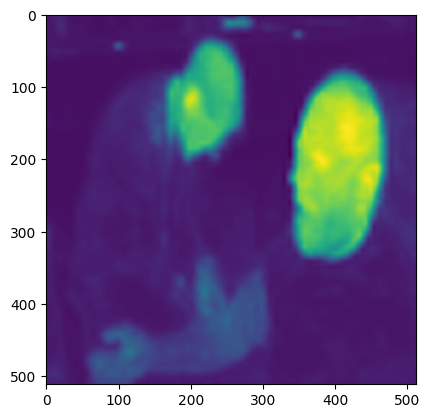

In [60]:
plt.imshow(heatmap)

In [61]:
len(annotations[1])

13

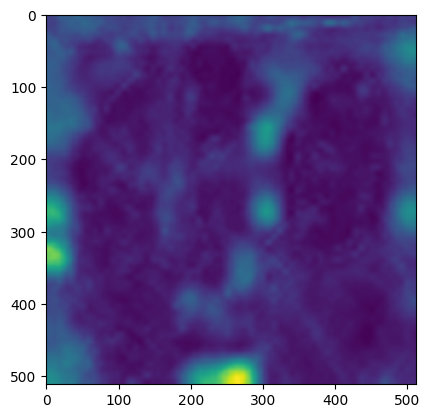

In [62]:
# plt.imshow(word_global_heat_map.compute_word_heat_map(processed_prompt[0][1][1]).expand_as(output_image[0]).numpy())
plt.imshow(word_global_heat_map.compute_word_heat_map(objects[1]).expand_as(output_image[0]).numpy())

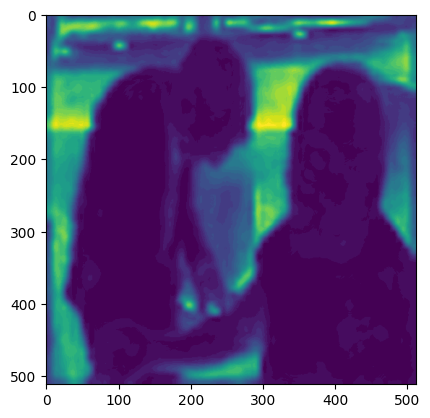

In [68]:
heatmaps = list()
for k in range(len(annotations[1])):
  # Compute heatmap for inner pixels for contour boundary specified
  pixel_heatmap = image_global_heat_map.compute_contour_heat_map(
      [[annotations[1][k]['segmentation'][0][i], annotations[1][k]['segmentation'][0][i+1]] for i in range(0, len(annotations[1][k]['segmentation'][0]), 2)], 
      512, 512).expand_as(output_image[0]).numpy()

  # Casting heatmap from 0-1 floating range to 0-255 unsigned 8 bit integer
  heatmap = np.array(pixel_heatmap * 255, dtype = np.uint8)

  heatmaps.append(heatmap[np.newaxis, :, :])

# computing mean of heatmaps
heatmap = np.mean(np.concatenate(heatmaps), 0)

# Casting heatmap from 0-1 floating range to 0-255 unsigned 8 bit integer
heatmap = np.array(heatmap, dtype = np.uint8)

plt.imshow(heatmap)

In [70]:
# word_heatmap
word_heat = word_global_heat_map.compute_word_heat_map(objects[1])

# To store weighted average of all the heatmaps with weights as the text heatmap pixel weights
pixel_heatmap = torch.zeros((image_global_heat_map.latent_h, image_global_heat_map.latent_w))

for i in range(image_global_heat_map.latent_h):
  for j in range(image_global_heat_map.latent_w):
    pixel_heatmap += image_global_heat_map.compute_pixel_heat_map(image_global_heat_map.latent_w * i + j).heatmap.cpu() * word_heat.heatmap.cpu()[i][j].item() ## word_heat is large need to cover it

pixel_heatmap /= word_heat.heatmap.cpu().sum().item()

pixel_heatmap = daami2i.PixelHeatMap(pixel_heatmap).expand_as(output_image[0]).numpy()

# # Casting heatmap from 0-1 floating range to 0-255 unsigned 8 bit integer
heatmap = np.array(pixel_heatmap * 255, dtype = np.uint8)    

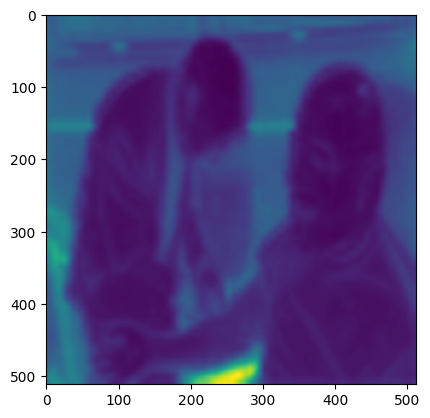

In [33]:
plt.imshow(heatmap)

In [72]:
# Combining both Contours and Weighted

inner_pix_list = list()
for k in range(len(annotations[1])):
  pts = [[annotations[1][k]['segmentation'][0][i], annotations[1][k]['segmentation'][0][i+1]] for i in range(0, len(annotations[1][k]['segmentation'][0]), 2)]
  pts = np.array(np.array(pts) * image_global_heat_map.latent_w / 512, np.int32)
  pts = pts.reshape((-1,1,2))
  inner_pixs = list()
  for i in range(64):
    for j in range(64):
      dist = cv2.pointPolygonTest(pts, (i, j), False)
      if dist == 1.0:
        inner_pixs.append((j*image_global_heat_map.latent_w) + i)
  inner_pix_list.append(inner_pixs)

# word_heatmap
word_heat = word_global_heat_map.compute_word_heat_map(objects[1])

# To store weighted average of all the heatmaps with weights as the text heatmap pixel weights
pixel_heatmap = torch.zeros((image_global_heat_map.latent_h, image_global_heat_map.latent_w))

for inner_pixs in inner_pix_list:
  for pix_id in inner_pixs:
    pixel_heatmap += image_global_heat_map.compute_pixel_heat_map(pix_id).heatmap.cpu() * word_heat.heatmap.cpu()[pix_id//image_global_heat_map.latent_w][pix_id%image_global_heat_map.latent_w].item() ## word_heat is large need to cover it

pixel_heatmap /= word_heat.heatmap.cpu().sum().item()

pixel_heatmap = daami2i.PixelHeatMap(pixel_heatmap).expand_as(output_image[0]).numpy()

# # Casting heatmap from 0-1 floating range to 0-255 unsigned 8 bit integer
heatmap = np.array(pixel_heatmap * 255, dtype = np.uint8)    

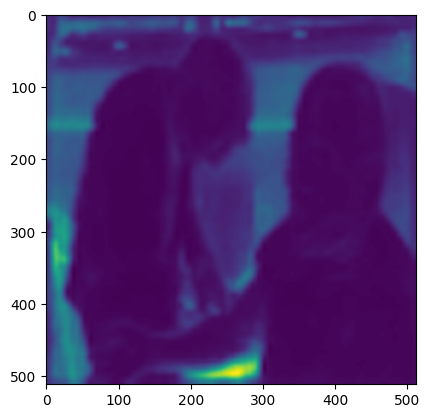

In [64]:
plt.imshow(heatmap)

### Object Detections

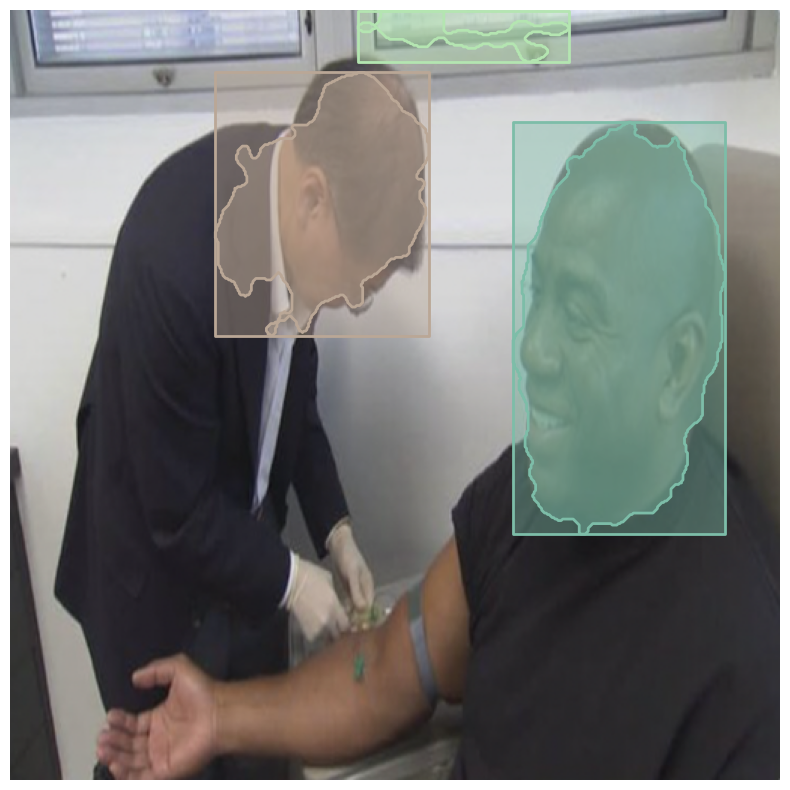

In [35]:
# Word Heatmap Version - Magic Johnson
object_annotator.show_annotations(np.asarray(init_img), annotations[0])

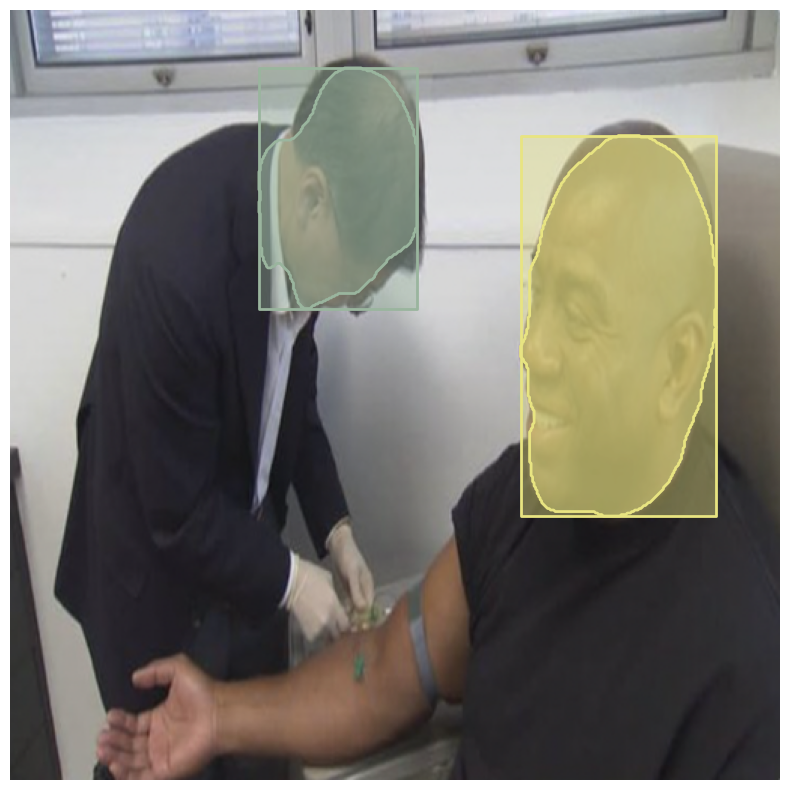

In [39]:
# Image Heatmap Version - Magic Johnson (Non Weighted)
object_annotator.show_annotations(np.asarray(init_img), object_annotator.wordheatmap_to_annotations(heatmap/255))

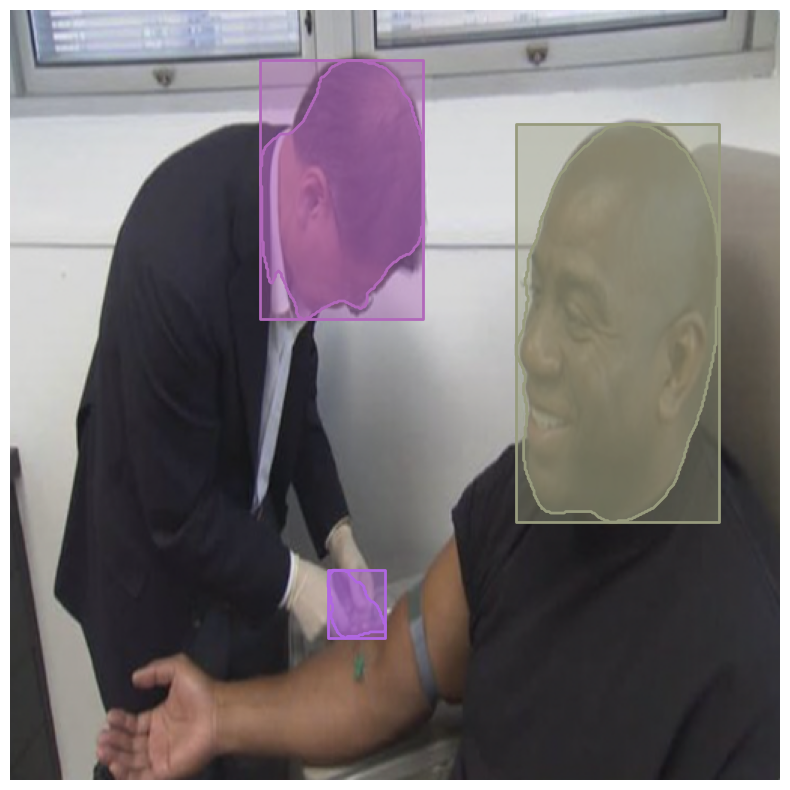

In [46]:
# Image Heatmap Version - Magic Johnson (Weighted)
object_annotator.show_annotations(np.asarray(init_img), object_annotator.wordheatmap_to_annotations(heatmap/255))

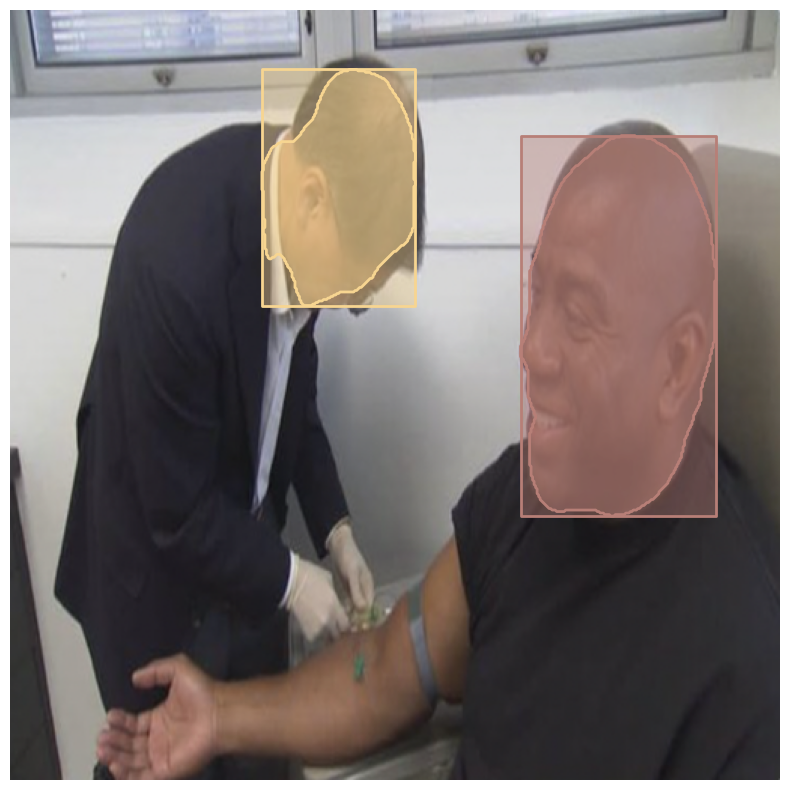

In [66]:
# Image Heatmap Version - Magic Johnson (Non-Weighted + Weighted)
object_annotator.show_annotations(np.asarray(init_img), object_annotator.wordheatmap_to_annotations(heatmap/255))

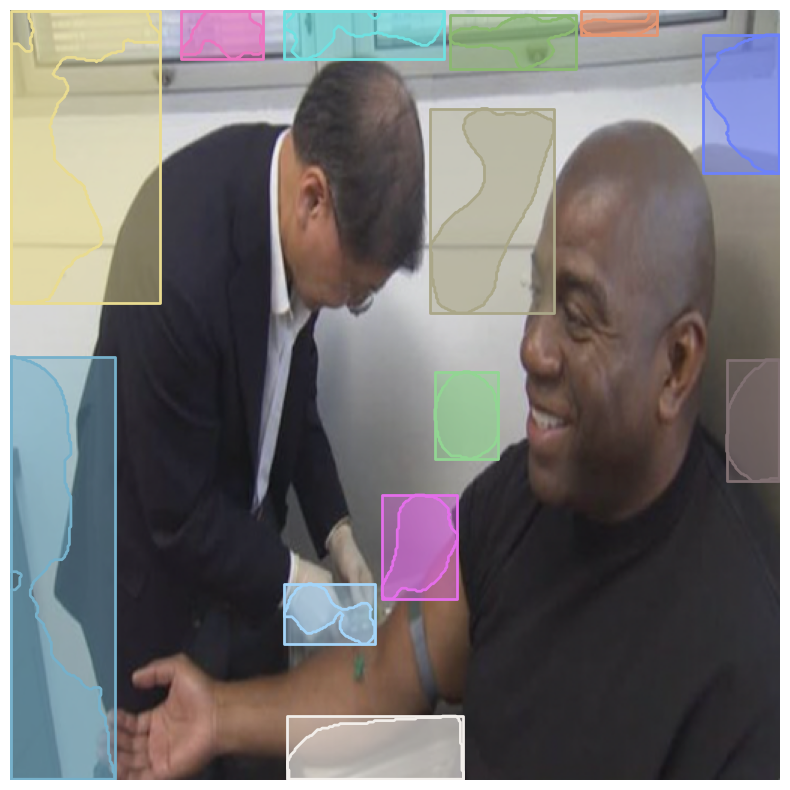

In [67]:
# Word Heatmap Version - Hospital
object_annotator.show_annotations(np.asarray(init_img), annotations[1])

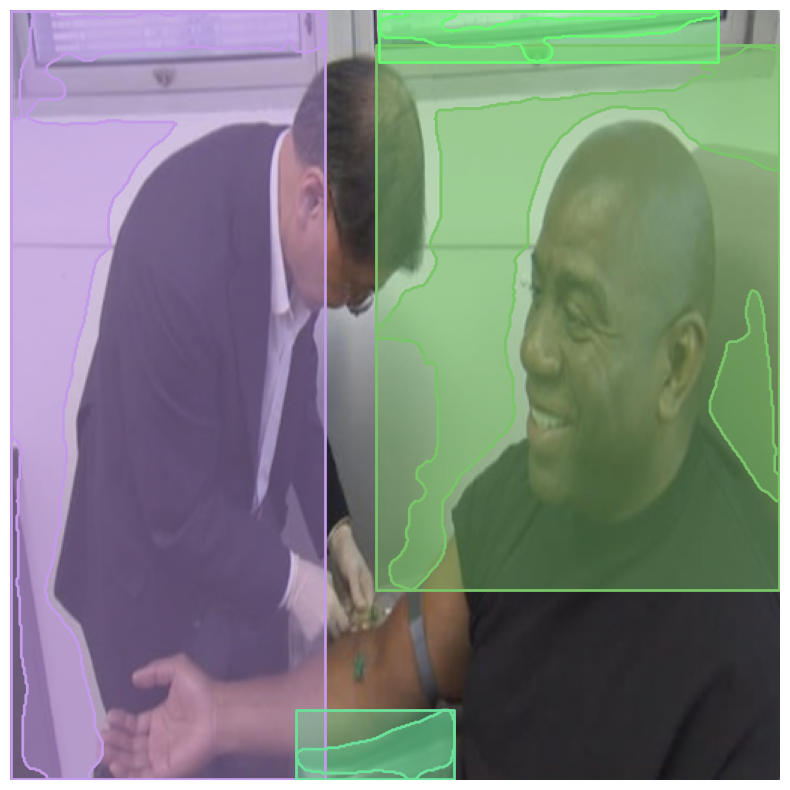

In [69]:
# Image Heatmap Version - Heatmap (Non-Weighted)
object_annotator.show_annotations(np.asarray(init_img), object_annotator.wordheatmap_to_annotations(heatmap/255))

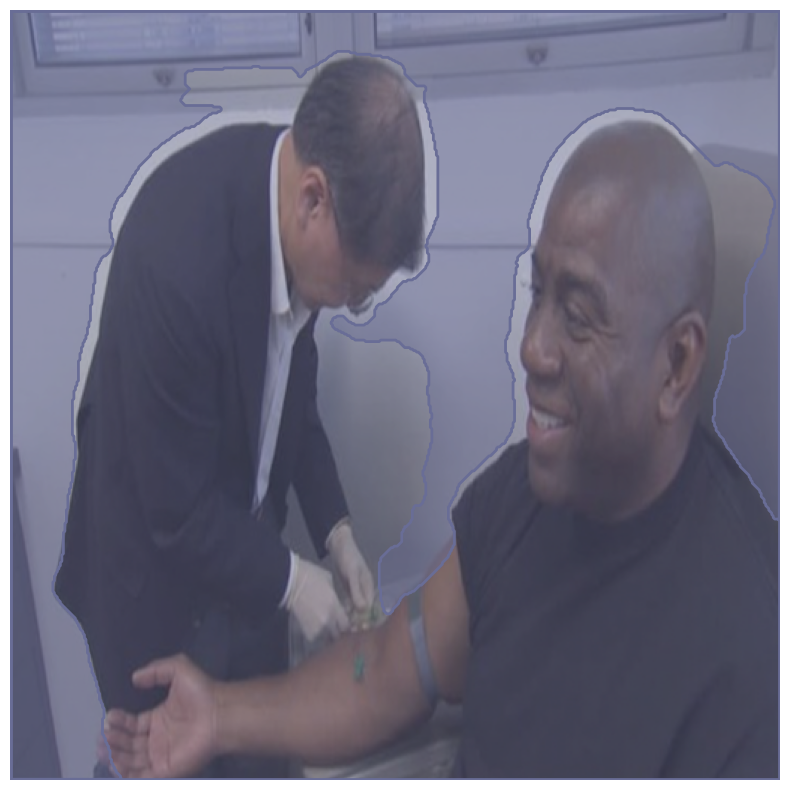

In [71]:
# Image Heatmap Version - Magic Johnson (Weighted)
object_annotator.show_annotations(np.asarray(init_img), object_annotator.wordheatmap_to_annotations(heatmap/255))

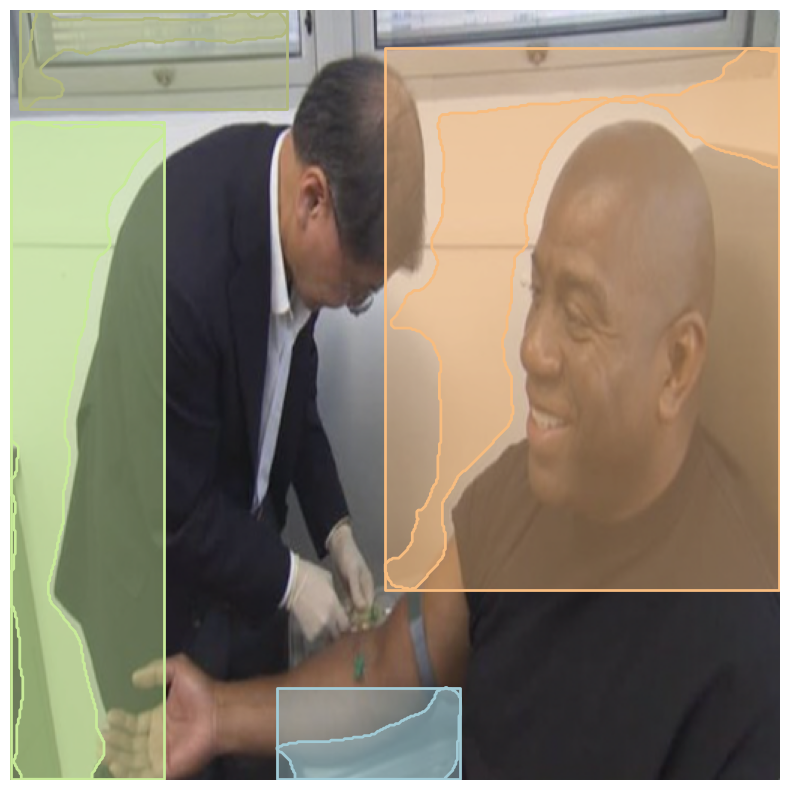

In [73]:
# Image Heatmap Version - Hospital (Non-Weighted + Weighted)
object_annotator.show_annotations(np.asarray(init_img), object_annotator.wordheatmap_to_annotations(heatmap/255))